# Deep Learning with PyTorch - Tomas Beuzen

Working through some examples:

[https://www.tomasbeuzen.com/deep-learning-with-pytorch/chapters/chapter3_pytorch-neural-networks-pt1.html](https://www.tomasbeuzen.com/deep-learning-with-pytorch/chapters/chapter3_pytorch-neural-networks-pt1.html)



In [5]:
import sys
import numpy as np
import pandas as pd
import torch
from torchinfo import summary
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_regression, make_circles, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Build a simple Linear Regression with a Neural Network

Use sklearn model as comparison:

In [7]:
X, y = make_regression(n_samples=500, n_features=1, random_state=0, noise=10.0)

sk_model = LinearRegression().fit(X, y)

print(f"w_0: {sk_model.intercept_:.2f} (bias/intercept)")
print(f"w_1: {sk_model.coef_[0]:.2f}")

w_0: -0.77 (bias/intercept)
w_1: 45.50


PyTorch version:

In [13]:
class linear_regression(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        out = self.linear(x)
        return out
            

In [14]:
model = linear_regression(input_size=1,
                         output_size=1,
                         )

In [15]:
print(model)

linear_regression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [20]:
summary(model, (1,))

Layer (type:depth-idx)                   Output Shape              Param #
linear_regression                        [1]                       --
├─Linear: 1-1                            [1]                       2
Total params: 2
Trainable params: 2
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [21]:
model.state_dict() # note that for now the weight and bias are initialized randomly so not meaningful

OrderedDict([('linear.weight', tensor([[-0.4944]])),
             ('linear.bias', tensor([0.8291]))])

In [26]:
# convert the X,y data to tensors

X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32)

In [27]:
X_t.device, y_t.device, X_t.dtype, y_t.dtype

(device(type='cpu'), device(type='cpu'), torch.float32, torch.float32)

In [32]:
# get test output
y_example = model(X_t[0])

y_example, y_example.item(), y_t[0].item() # y_t[0] is actual value to be predicted

(tensor([0.5224], grad_fn=<ViewBackward0>),
 0.522416889667511,
 31.07604217529297)

In [33]:
LEARNING_RATE = 0.1
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),
                           lr=LEARNING_RATE)

In [34]:
len(X_t)

500

In [36]:
# we'll make batch size = 50 -> 500/50 = 10 total batches therefore
BATCH_SIZE = 50

dataset = TensorDataset(X_t,
                       y_t)

dataloader = DataLoader(dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=True) # train dataloader so do shuffle

In [37]:
# test dataloader
print(next(iter(dataloader)))

[tensor([[-0.1872],
        [ 0.5531],
        [ 0.9433],
        [-0.1073],
        [ 0.3901],
        [-1.6165],
        [ 1.3018],
        [-1.0931],
        [-0.0739],
        [ 0.0105],
        [ 0.7863],
        [ 1.5328],
        [-0.8541],
        [ 1.7641],
        [ 1.1170],
        [ 2.1632],
        [ 1.1369],
        [-0.0393],
        [-2.6592],
        [ 0.8025],
        [-1.2705],
        [ 0.3025],
        [ 0.4161],
        [-2.0164],
        [ 0.4439],
        [-2.2234],
        [-0.6374],
        [ 0.7066],
        [ 0.4938],
        [-0.1799],
        [ 0.5830],
        [-0.9646],
        [-1.5408],
        [ 0.1567],
        [-1.0600],
        [-0.1514],
        [ 0.8006],
        [-1.6021],
        [ 0.7718],
        [-0.4616],
        [ 0.2515],
        [ 0.9008],
        [-0.8909],
        [ 1.0777],
        [-1.0799],
        [ 0.2671],
        [ 0.9060],
        [-0.1032],
        [-0.6510],
        [ 0.6985]]), tensor([ -33.2506,   35.2488,   44.3095,  -14.3

In [39]:
# -- TRAINING --

def trainer(model,
           criterion,
           optimizer,
           dataloader,
           epochs=5,
           verbose=True):
    for epoch in range(epochs):
        losses = 0
        for X, y in dataloader:
            optimizer.zero_grad() # clear gradients
            y_predictions = model(X).flatten() # forward pass
            loss = criterion(y_predictions, y) # calculate loss
            loss.backward() # backprop
            optimizer.step() # update parameters
            losses += loss.item() # add loss from this batch to the running total
        if verbose:
            print(f"- Epoch {epoch + 1} : loss = {losses / len(dataloader)}")

trainer(model,
       criterion,
       optimizer,
       dataloader,
       )
            



- Epoch 1 : loss = 691.296102142334
- Epoch 2 : loss = 100.13624877929688
- Epoch 3 : loss = 93.84911499023437
- Epoch 4 : loss = 94.08947296142578
- Epoch 5 : loss = 93.49924774169922


In [40]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[45.5159]])),
             ('linear.bias', tensor([-1.3964]))])

In [41]:
# we note that our params are indeed different than they were before - how good are they compared to SKLEARN answer?

pd.DataFrame({"w0": [sk_model.intercept_, model.state_dict()['linear.bias'].item()],
              "w1": [sk_model.coef_[0], model.state_dict()['linear.weight'].item()]},
             index=['sklearn', 'pytorch']).round(2)

,w0,w1
sklearn,-0.77,45.50
pytorch,-1.40,45.52


In [42]:
# INTERESTING NOTE -- care! if you  run trainer() again, the model CONTINUES WHERE WE LEFT OFF
# since we didn't restart our model or optimizer

trainer(model,
       criterion,
       optimizer,
       dataloader,
       )
           

- Epoch 1 : loss = 93.5334083557129
- Epoch 2 : loss = 93.5994155883789
- Epoch 3 : loss = 93.74618225097656
- Epoch 4 : loss = 93.56541900634765
- Epoch 5 : loss = 93.79178161621094


# Multiple Linear Regression with a Neural Network

In [43]:
# Create dataset - WITH 3 FEATURES NOW 
X, y = make_regression(n_samples=500, n_features=3, random_state=0, noise=10.0)
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32)

# Create dataloader
dataset = TensorDataset(X_t, y_t)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [44]:
model = linear_regression(input_size=3,
                         output_size=1) # CARE! output size doesn't change ofc

In [49]:
summary(model, (3,))

#summary(model) # need to understand the difference with these options 

Layer (type:depth-idx)                   Output Shape              Param #
linear_regression                        [1]                       --
├─Linear: 1-1                            [1]                       4
Total params: 4
Trainable params: 4
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [51]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

trainer(model, criterion, optimizer, dataloader)

- Epoch 1 : loss = 102.39378204345704
- Epoch 2 : loss = 102.12321624755859
- Epoch 3 : loss = 101.8287254333496
- Epoch 4 : loss = 101.98360671997071
- Epoch 5 : loss = 102.49278717041015


In [52]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[ 0.3941, 55.8090, 11.4058]])),
             ('linear.bias', tensor([0.1724]))])

In [53]:
# compare with sklearn
sk_model = LinearRegression().fit(X, y)
pd.DataFrame({"w0": [sk_model.intercept_, model.state_dict()['linear.bias'].item()],
              "w1": [sk_model.coef_[0], model.state_dict()['linear.weight'][0, 0].item()],
              "w2": [sk_model.coef_[1], model.state_dict()['linear.weight'][0, 1].item()],
              "w3": [sk_model.coef_[2], model.state_dict()['linear.weight'][0, 2].item()]},
             index=['sklearn', 'pytorch']).round(2)

,w0,w1,w2,w3
sklearn,0.43,0.62,55.99,11.14
pytorch,0.17,0.39,55.81,11.41


# Non-linear Regression with a Neural Network

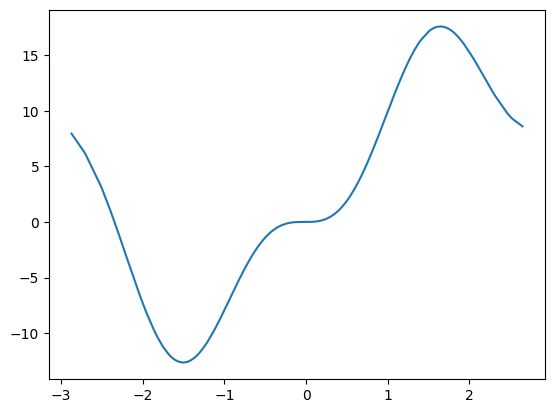

In [56]:
# Create dataset
np.random.seed(2020)
X = np.sort(np.random.randn(500))
y = X ** 2 + 15 * np.sin(X) **3

X_t = torch.tensor(X[:, None], dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32)

# Create dataloader
dataset = TensorDataset(X_t, y_t)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

from matplotlib import pyplot as plt
plt.plot(X,y)
plt.show()

This is obviously non-linear, and we need to introduce some non-linearities into our network. These non-linearities are what make neural networks so powerful and they are called “activation functions”. We are going to create a new model class that includes a non-linearity - a sigmoid function

S(x) = 1 / (1 + exp(-x))

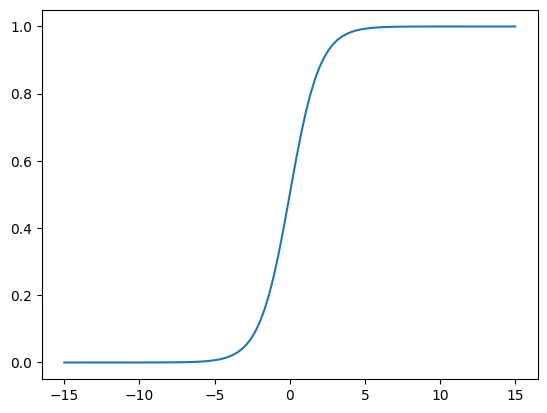

In [57]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

xs = np.linspace(-15, 15, 100)
plt.plot(xs, sigmoid(xs))
plt.show()

Create a network with 1 hidden layer of 3 neurons

2 ways of creating such a model :

## First way



In [59]:
class nonlinear_regression_first_approach(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden(x)       # input -> hidden layer
        x = self.sigmoid(x)      # sigmoid activation function in hidden layer
        x = self.output(x)       # hidden -> output layer
        return x

## Second way - use nn.Sequential() to combine the layers together in the constructor itself

In [60]:
class nonlinear_regression(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.main = torch.nn.Sequential(
            nn.Linear(input_size, hidden_size),  # input -> hidden layer
            nn.Sigmoid(),                        # sigmoid activation function in hidden layer
            nn.Linear(hidden_size, output_size)  # hidden -> output layer
        )

    def forward(self, x):
        x = self.main(x)
        return x

In [62]:
model = nonlinear_regression(1, 3, 1)
summary(model, (1,))

Layer (type:depth-idx)                   Output Shape              Param #
nonlinear_regression                     [1]                       --
├─Sequential: 1-1                        [1]                       --
│    └─Linear: 2-1                       [3]                       6
│    └─Sigmoid: 2-2                      [3]                       --
│    └─Linear: 2-3                       [1]                       4
Total params: 10
Trainable params: 10
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [63]:
# -- TRAINING --
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.3)
trainer(model, criterion, optimizer, dataloader, epochs=5, verbose=True)

- Epoch 1 : loss = 39.96995258331299
- Epoch 2 : loss = 21.244226360321044
- Epoch 3 : loss = 9.12611427307129
- Epoch 4 : loss = 6.785511040687561
- Epoch 5 : loss = 4.921653771400452


In [64]:
y_preds = model(X_t).detach().numpy().squeeze()

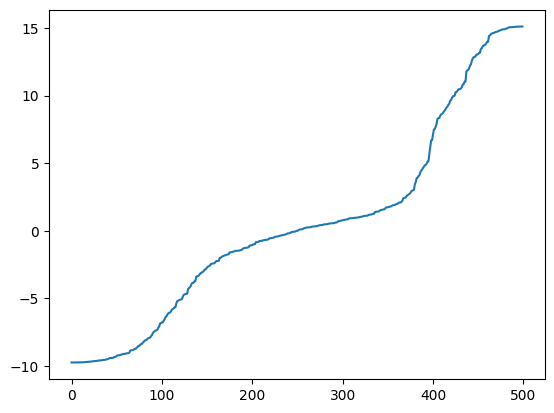

In [65]:
plt.plot(y_preds)